In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
import matplotlib.patches as mpatches
from DifferentiableHOS.Fisher import fisher
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60

In [3]:
kmaps = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/maps/"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/maps/', filename), 'rb'))
        kmaps.append(res['kmap'])

2022-08-04 08:25:49.807263: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 08:25:50.338734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38280 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [5]:
from flowpm.fourier_smoothing import fourier_smoothing
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10
    pix_scale = field_size / field_npix * 60
    ngal_per_pix = ngal * pix_scale**2
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    return kmap

In [6]:
bins=tf.linspace(-.1, 1.,8)
rangev=[-.1,1.]
pcounts_5_6_7=[]
ps=[]
for i in range(len(kmaps)):
    kmap = desc_y1_analysis(kmaps[i])
    ell,p=DHOS.statistics.power_spectrum_mulscale(kmap, field_size,field_npix)
    ell = ell[2:46]
    p = p[2:46]
    ell = rebin(ell, 11)
    p = rebin(p, 11)
    counts_5_6_7,bins_=DHOS.statistics.peaks_histogram_tf_mulscale(kmap,nscales=7,bins=bins)
    counts_5_6_7=counts_5_6_7[4:7]
    pcounts_5_6_7.append(counts_5_6_7)
    ps.append(p)

2022-08-04 08:26:05.340570: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-04 08:26:05.427089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-08-04 08:26:07.340148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
ps = stack(ps, axis=0)
pcounts_5_6_7 = stack(pcounts_5_6_7, axis=0)

In [8]:
ps_mean=ps.mean(axis=0)
pcounts_mean_5_6_7=pcounts_5_6_7.mean(axis=0)

In [9]:
ps_jac= []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale', filename), 'rb'))
        ps_jac.append(res['jac'])
        
        
pcounts_jac_5_6_7 = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts', filename), 'rb'))
        pcounts_jac_5_6_7 .append(res['jac'])

In [10]:
ps_jac= stack(ps_jac, axis=0)
pcounts_jac_5_6_7 = stack(pcounts_jac_5_6_7, axis=0)

# Results without IA

In [11]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$"]
xyrange=[[0.1,0.5],[0.6,0.9],[0.025,0.1],[0.8,1.2],[0.5,0.8],[-1.1,-0.9]]

In [12]:
#The way to use this:
fid_cosmo = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0}

In [13]:
# Computing covariance matrix
f_sky=25/150000

cov_ps=np.cov(tf.reshape(ps,[len(ps),11]), rowvar=False)*f_sky
cov_pcounts_5_6_7=np.cov(tf.reshape(pcounts_5_6_7[:,:,:],[len(pcounts_5_6_7),24]), rowvar=False)*f_sky



dmu_ps = ps_jac[:,...,:6].mean(axis=0)
dmu_pcounts_5_6_7 = tf.reshape(pcounts_jac_5_6_7[:,:,:,:6],[len(pcounts_jac_5_6_7),24,6]).numpy().mean(axis=0)


Fpcounts_5_6_7 = dmu_pcounts_5_6_7.T @ (np.linalg.inv(cov_pcounts_5_6_7)) @ dmu_pcounts_5_6_7
Fps = dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps

fisher_object_pcounts_5_6_7 = fisher(Fpcounts_5_6_7, labels,  fid_cosmo)
fisher_object_ps = fisher(Fps, labels,  fid_cosmo)

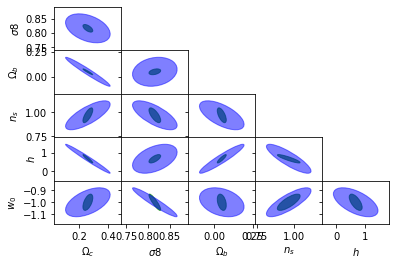

In [14]:
fisher_object_pcounts_5_6_7.corner_plot(color='green',alpha=0.7)
fisher_object_ps.corner_plot(color='blue',alpha=0.5)

# Results with IA 

In [15]:
labels_IA=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$","$A_{IA}$"]

xyrange_IA=[[0.1,0.5],[0.6,0.9],[0.025,0.1],[0.8,1.2],[0.5,0.8],[-1.1,-0.9],[-1.,1.]]

In [16]:
#The way to use this:
fid_cosmo_IA = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0,
            "$A_{IA}$": 0.}

In [17]:
# Computing covariance matrix
f_sky=25/150000

cov_ps=np.cov(tf.reshape(ps,[len(ps),11]), rowvar=False)*f_sky
cov_pcounts_5_6_7=np.cov(tf.reshape(pcounts_5_6_7[:,:,:],[len(pcounts_5_6_7),24]), rowvar=False)*f_sky


dmu_ps_IA = ps_jac.mean(axis=0)
dmu_pcounts_IA_5_6_7 = tf.reshape(pcounts_jac_5_6_7[:,:,:,:],[len(pcounts_jac_5_6_7),24,7]).numpy().mean(axis=0)


Fps_IA = dmu_ps_IA.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_IA
Fpcounts_IA_5_6_7 = dmu_pcounts_IA_5_6_7.T @ (np.linalg.inv(cov_pcounts_5_6_7)) @ dmu_pcounts_IA_5_6_7

fisher_object_ps_IA = fisher(Fps_IA, labels_IA,  fid_cosmo_IA)
fisher_object_pcounts_IA_5_6_7 = fisher(Fpcounts_IA_5_6_7, labels_IA,  fid_cosmo_IA)


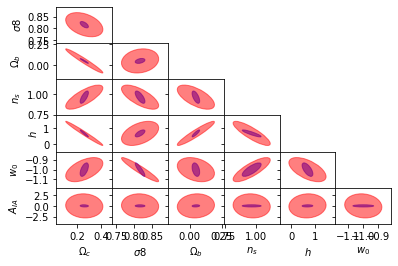

In [18]:
fisher_object_pcounts_IA_5_6_7.corner_plot(color='blue',alpha=0.6)
fisher_object_ps_IA.corner_plot(color='red',alpha=0.5)
#scale all


In [19]:
cov_pcounts_5=np.cov(tf.reshape(pcounts_5_6_7[:,0,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
dmu_pcounts_IA_5 = tf.reshape(pcounts_jac_5_6_7[:,0,:,:],[len(pcounts_jac_5_6_7),8,7]).numpy().mean(axis=0)
Fpcounts_IA_5= dmu_pcounts_IA_5.T @ (np.linalg.inv(cov_pcounts_5)) @ dmu_pcounts_IA_5
fisher_object_pcounts_IA_5 = fisher(Fpcounts_IA_5, labels_IA,  fid_cosmo_IA)


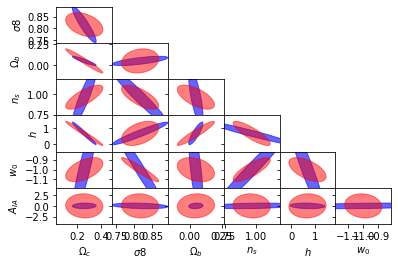

In [32]:

fisher_object_pcounts_IA_5.corner_plot(color='blue',alpha=0.6)
fisher_object_ps_IA.corner_plot(color='red',alpha=0.5)
#scale 5


In [21]:
cov_pcounts_6=np.cov(tf.reshape(pcounts_5_6_7[:,1,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
dmu_pcounts_IA_6 = tf.reshape(pcounts_jac_5_6_7[:,1,:,:],[len(pcounts_jac_5_6_7),8,7]).numpy().mean(axis=0)
Fpcounts_IA_6= dmu_pcounts_IA_6.T @ (np.linalg.inv(cov_pcounts_6)) @ dmu_pcounts_IA_6
fisher_object_pcounts_IA_6 = fisher(Fpcounts_IA_6, labels_IA,  fid_cosmo_IA)


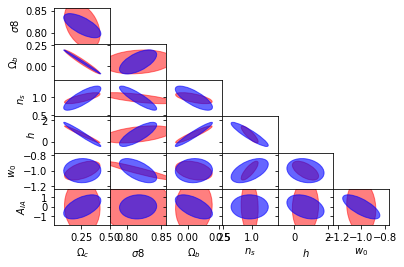

In [22]:
fisher_object_ps_IA.corner_plot(color='red',alpha=0.5)
fisher_object_pcounts_IA_6.corner_plot(color='blue',alpha=0.6)
#scale 6


In [23]:
cov_pcounts_7=np.cov(tf.reshape(pcounts_5_6_7[:,2,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
dmu_pcounts_IA_7 = tf.reshape(pcounts_jac_5_6_7[:,2,:,:],[len(pcounts_jac_5_6_7),8,7]).numpy().mean(axis=0)
Fpcounts_IA_7= dmu_pcounts_IA_7.T @ (np.linalg.inv(cov_pcounts_7)) @ dmu_pcounts_IA_7
fisher_object_pcounts_IA_7 = fisher(Fpcounts_IA_7, labels_IA,  fid_cosmo_IA)

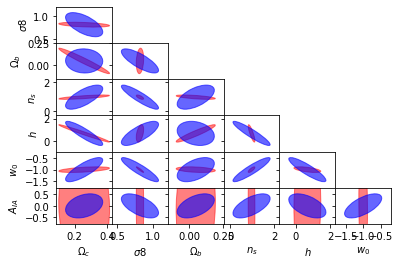

In [24]:
fisher_object_ps_IA.corner_plot(color='red',alpha=0.5)
fisher_object_pcounts_IA_7.corner_plot(color='blue',alpha=0.6)
#scale 7

In [25]:
cov_pcounts_5_6=np.cov(tf.reshape(pcounts_5_6_7[:,:2,:],[len(pcounts_5_6_7),16]), rowvar=False)*f_sky
dmu_pcounts_IA_5_6 = tf.reshape(pcounts_jac_5_6_7[:,:2,:,:],[len(pcounts_jac_5_6_7),16,7]).numpy().mean(axis=0)
Fpcounts_IA_5_6= dmu_pcounts_IA_5_6.T @ (np.linalg.inv(cov_pcounts_5_6)) @ dmu_pcounts_IA_5_6
fisher_object_pcounts_IA_5_6 = fisher(Fpcounts_IA_5_6, labels_IA,  fid_cosmo_IA)


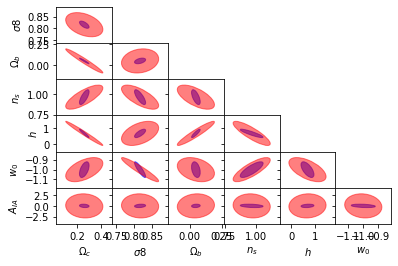

In [26]:
fisher_object_pcounts_IA_5_6.corner_plot(color='blue',alpha=0.6)
fisher_object_ps_IA.corner_plot(color='red',alpha=0.5)
#scale 5 and 6


In [27]:
from flowpm.fourier_smoothing import fourier_smoothing
from DifferentiableHOS.transforms import starlet2d

In [28]:
image = tf.cast(kmaps[0], dtype=tf.float32)
wt = tf.stack(starlet2d(image, 7, padding='SAME'),axis=0)[4:7]

(-0.5, 1023.5, 1023.5, -0.5)

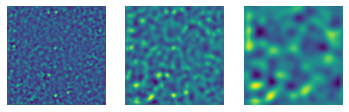

In [29]:
subplot(131)
imshow(tf.reshape(wt[0], [1024, 1024]))
axis('off')
subplot(132)
imshow(tf.reshape(wt[1], [1024, 1024]))
axis('off')
subplot(133)
imshow(tf.reshape(wt[2], [1024, 1024]))
axis('off')